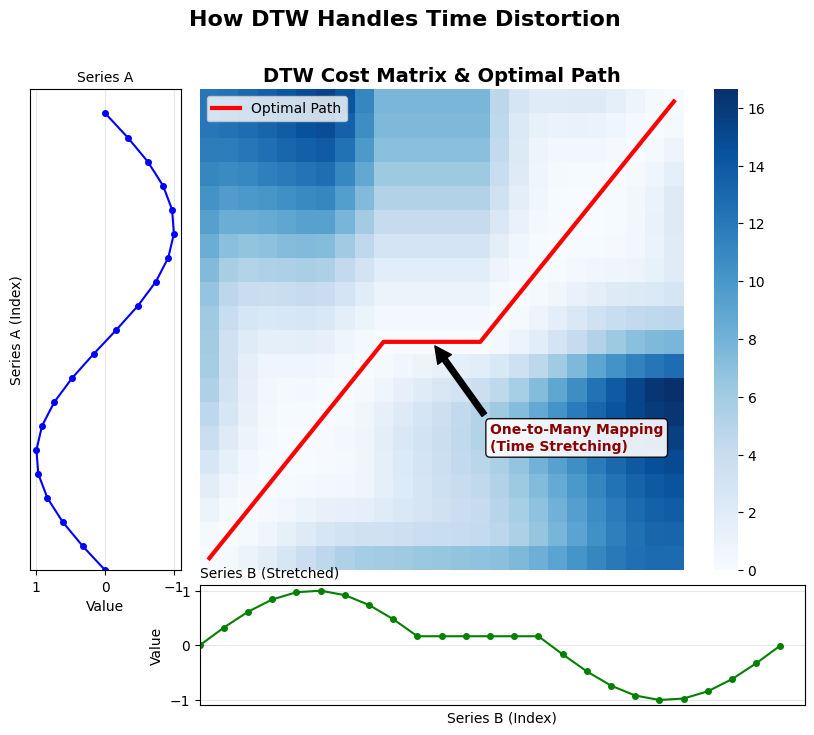

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

def compute_dtw(s1, s2):
    """
    簡單的 DTW 演算法實作，回傳累積成本矩陣與最佳路徑
    """
    n, m = len(s1), len(s2)
    dtw_matrix = np.zeros((n + 1, m + 1))
    
    # 初始化：設為無限大
    dtw_matrix.fill(np.inf)
    dtw_matrix[0, 0] = 0
    
    # 動態規劃填表
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(s1[i-1] - s2[j-1])
            # 取左上、上、左的最小值 + 當前距離
            last_min = min(dtw_matrix[i-1, j],    # Insertion
                           dtw_matrix[i, j-1],    # Deletion
                           dtw_matrix[i-1, j-1])  # Match
            dtw_matrix[i, j] = cost + last_min
            
    # 回溯找路徑 (Backtracking)
    path = []
    i, j = n, m
    while i > 0 and j > 0:
        path.append((j-1, i-1)) # 注意存的是 (x, y) 座標
        current = dtw_matrix[i, j]
        # 找來源
        if i > 0 and j > 0 and dtw_matrix[i-1, j-1] <= dtw_matrix[i-1, j] and dtw_matrix[i-1, j-1] <= dtw_matrix[i, j-1]:
            i -= 1; j -= 1
        elif i > 0 and dtw_matrix[i-1, j] <= dtw_matrix[i, j-1]:
            i -= 1
        else:
            j -= 1
    path.reverse()
    
    # 回傳切掉 padding 的矩陣
    return dtw_matrix[1:, 1:], path

def plot_dtw_mechanism():
    # 1. 準備數據：兩個相似但拉伸的序列
    # s1: 標準的正弦波
    x = np.linspace(0, 3.14 * 2, 20)
    s1 = np.sin(x)
    
    # s2: 拉伸過的正弦波 (模擬中間停頓了一下)
    # 我們重複中間幾個點來模擬 "Stretching" (One-to-Many)
    s2 = np.concatenate([s1[:10], [s1[9]]*5, s1[10:]]) 
    
    # 2. 計算 DTW
    cost_matrix, path = compute_dtw(s1, s2)
    path_x = [p[0] + 0.5 for p in path] # +0.5 讓線畫在格子中間
    path_y = [p[1] + 0.5 for p in path]

    # 3. 設定畫布佈局 (GridSpec)
    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(2, 2, width_ratios=[1, 4], height_ratios=[4, 1], wspace=0.05, hspace=0.05)

    # 主圖：成本矩陣 (右上)
    ax_main = fig.add_subplot(gs[0, 1])
    sns.heatmap(cost_matrix, cmap="Blues", cbar=True, ax=ax_main, xticklabels=False, yticklabels=False)
    ax_main.invert_yaxis() # 讓 (0,0) 在左下角
    
    # 畫出最佳路徑
    ax_main.plot(path_x, path_y, 'r-', linewidth=3, label='Optimal Path')
    
    # 標註 "One-to-Many" (水平線段)
    # 找出路徑中明顯水平的地方
    ax_main.annotate('One-to-Many Mapping\n(Time Stretching)', 
                     xy=(12, 9.5), xytext=(15, 5),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=10, fontweight='bold', color='darkred',
                     bbox=dict(boxstyle="round", fc="white", alpha=0.9))

    ax_main.set_title("DTW Cost Matrix & Optimal Path", fontsize=14, fontweight='bold')
    ax_main.legend(loc='upper left')

    # 左側圖：序列 S1 (Y軸)
    ax_left = fig.add_subplot(gs[0, 0], sharey=ax_main)
    ax_left.plot(s1, range(len(s1)), 'b-o', markersize=4)
    ax_left.set_ylim(0, len(s1))
    ax_left.invert_xaxis() # 讓波形靠右，貼近矩陣
    ax_left.set_xlabel("Value")
    ax_left.set_ylabel("Series A (Index)")
    ax_left.grid(True, alpha=0.3)
    ax_left.set_title("Series A", fontsize=10)

    # 下方圖：序列 S2 (X軸)
    ax_bottom = fig.add_subplot(gs[1, 1], sharex=ax_main)
    ax_bottom.plot(range(len(s2)), s2, 'g-o', markersize=4)
    ax_bottom.set_xlim(0, len(s2))
    ax_bottom.set_ylabel("Value")
    ax_bottom.set_xlabel("Series B (Index)")
    ax_bottom.grid(True, alpha=0.3)
    ax_bottom.set_title("Series B (Stretched)", fontsize=10, loc='left')

    plt.suptitle("How DTW Handles Time Distortion", fontsize=16, fontweight='bold', y=0.98)
    
    # 儲存
    plt.savefig('dtw_mechanism.png')
    plt.show()

if __name__ == "__main__":
    plot_dtw_mechanism()